In [492]:
#documentation: https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
from sklearn.ensemble import RandomForestClassifier
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.io.wavfile as wav
import glob
import sys
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import librosa

In [493]:
import os

if os.getcwd().endswith("Calculator") == True or \
   os.getcwd().endswith("Calculator\\") == True or \
   os.getcwd().endswith("Calculator/") == True :
    cwd = os.getcwd()

print(cwd)

C:\Users\qan96\Documents\GitHub\Audio-Calculator


In [494]:
def join_features(mfcc, fbank):
    features = np.concatenate((mfcc, fbank), axis=1)
    return features

truncate_threshold = 0.1
truncate_size = 10000.0
pre_emphasis = 0.97

def normalize(signal):
    result = abs(signal).copy().astype('float64')
    xmin = np.min(result)
    xmax = np.max(result)
    for i in range(0, signal.size):
        result[i] = (result[i] - xmin) / (xmax - xmin)
        result[i] = "%.2f" % result[i]
    
    return result

def calculate_normalized_entropy(signal):
    #normalize
    signal = normalize(signal)
    
    p = np.zeros(101)
    for i in range(0, signal.size):
        p[(signal[i] / 0.01).astype('int64')] += 1
    
    p = p / signal.size
    max_entro = 0.0
    min_entro = 1.0
    entropy = np.zeros(signal.size)
    
    for i in range(0, signal.size):
        index = (signal[i] / 0.01).astype('int64')
        entropy[i] = -p[index]*math.log2(p[index])
        max_entro = max(max_entro, entropy[i])
        min_entro = min(min_entro, entropy[i])
        
    for i in range(0,100):
        if p[i] == 0:
            continue
        #print(-p[i]*math.log2(p[i]))
        
    lamb = (max_entro - min_entro) / 2.0
    return entropy, lamb
    
def plot_sig(sig, ylabel):
    plt.figure()
    plt.plot(sig)
    plt.xlabel("time [s]")
    plt.ylabel(ylabel)
    plt.show()

def preprocess(sig):
    #sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])
    
    start_point = 0
    threshold = 0.1
    norm_sig = normalize(sig)
    np.set_printoptions(threshold=sys.maxsize)
    
    for i in range(0, sig.size):
        if norm_sig[i] >= truncate_threshold:
            start_point = i
            break
    
    stop_point = sig.size
    for i in reversed(range(0, sig.size)):
        if norm_sig[i] >= (truncate_threshold):
            stop_point = i
            break
    
    #print("start point", start_point)
    #print("stop point", stop_point)
    sig = sig[start_point:stop_point]
    #print(sig.size)
    
    #strech sig to 6000
    sig = librosa.core.resample(sig, sig.size, truncate_size)
    
    #sig = truncate_sig(sig)
    
    return sig
    
def read_file(files, label, enable_plot):
    features = []
    labels = []
    for file in files:
        (rate,sig) = wav.read(file)
        
        sig, sample_rate = librosa.core.load(file)
        #entropy, lamb = calculate_normalized_entropy(sig)
        
        if enable_plot == True:
            plot_sig(sig, "before")
        
        sig = preprocess(sig)
        
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)    
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        features.append(acoustic_features)
        labels.append(label)
        
        if enable_plot == True:
            plot_sig(sig, "after")
        
    return features, labels
        
digit_feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine"]

feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine", "plus", "minus", "times", "over"]

op_feature_types = ["plus", "minus", "times", "over"]

In [495]:
digit_features = []
digit_labels = []
op_features = []
op_labels = []
for i in digit_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    digit_features.extend(features)
    digit_labels.extend(labels)
    print(i, "finished")

for i in operator_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    op_features.extend(features)
    op_labels.extend(labels)
    
    print(i, "finished")
    
print("Input and preprocessing finished")

zero finished
one finished
two finished
three finished
four finished
five finished
six finished
seven finished
eight finished
nine finished


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


plus finished
minus finished
times finished
over finished
Input and preprocessing finished


In [496]:
digit_features = np.asarray(digit_features)
digit_labels = np. asarray(digit_labels)
op_features = np.asarray(op_features)
op_labels = np. asarray(op_labels)

digit_features_backup = digit_features.copy()
digit_labels_backup = digit_labels.copy()
op_features_backup = op_features.copy()
op_labels_backup = op_labels.copy()


(2000, 4836)
(2000,)
(389, 4836)
(389,)


In [615]:
digit_features = digit_features_backup.copy()
digit_labels = digit_labels_backup.copy()

print(digit_features.shape)
print(digit_labels.shape)

print(op_features.shape)
print(op_labels.shape)

(2000, 4836)
(2000,)
(389, 4836)
(389,)


In [616]:
#validate features and labels
for i in range(1, digit_features.shape[0]):
    if digit_features[i].size != digit_features[0].size:
        print("digit features", i)
        print(digit_features[i].size)
    if digit_labels[i].size != 1:
        print("digit labels", i)
        print(digit_labels[i].size)


digit_train_set, digit_test_set, digit_train_label, digit_test_label = train_test_split(digit_features, digit_labels, test_size=1.0/7.0, random_state=0, stratify=digit_labels)
op_train_set, op_test_set, op_train_label, op_test_label = train_test_split(op_features, op_labels, test_size=1.0/7.0, random_state=0, stratify=op_labels)

In [617]:
digit_scaler = StandardScaler()
# Fit on training set only.
digit_scaler.fit(digit_features)

digit_train_set = digit_scaler.transform(digit_train_set)
digit_test_set = digit_scaler.transform(digit_test_set)

digit_pca = PCA(.95)
digit_pca.fit(digit_features)
digit_train_set = digit_pca.transform(digit_train_set)
digit_test_set = digit_pca.transform(digit_test_set)

print(digit_train_set.shape)
print(digit_test_set.shape)

(1714, 331)
(286, 331)


In [618]:
digit_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000)

digit_logisticRegr.fit(digit_train_set, digit_train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [603]:
# Predict for One Observation (image)

# for i in range(0, digit_test_set.shape[0]):
#     if test_label[i] in digit_feature_types:
#         result = digit_logisticRegr.predict(digit_test_set[i].reshape(1,-1))
#         if (result != digit_test_label[i]):
#             print("Correct result:" + digit_test_label[i])
#             print(result)
    
print("test set accuracy: ", digit_logisticRegr.score(digit_test_set, digit_test_label) * 100, "%")
print("train set accuracy: ", digit_logisticRegr.score(digit_train_set, digit_train_label) * 100, "%")

test set accuracy:  78.32167832167832 %
train set accuracy:  100.0 %


In [502]:
op_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2')

op_logisticRegr.fit(op_train_set, op_train_label)

C:\Users\qan96\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [503]:
for i in range(0, op_test_set.shape[0]):
    if test_label[i] in op_feature_types:
        result = op_logisticRegr.predict(op_test_set[i].reshape(1,-1))
        if (result != op_test_label[i]):
            print("Correct result:" + op_test_label[i])
            print(result)
    
print("test set accuracy: ", op_logisticRegr.score(op_test_set, op_test_label) * 100, "%")
print("train set accuracy: ", op_logisticRegr.score(op_train_set, op_train_label) * 100, "%")

test set accuracy:  92.85714285714286 %
train set accuracy:  100.0 %


In [608]:
digit_rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)



digit_rfc.fit(X_train, y_train)
#checking the accuracy of the model
print(digit_rfc.score(X_val, y_val))

0.8811188811188811


In [506]:
op_rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)
op_rfc.fit(X_train, y_train)

#checking the accuracy of the model
print(op_rfc.score(X_val, y_val))

0.9487179487179487


In [612]:
def read_and_test_file(directory, t = "digit"):
    os.chdir(cwd+"\\recording data\\"+directory)
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    for file in files:
        (rate,sig) = wav.read(file)
        sig, sample_rate = librosa.core.load(file)
        plot_sig(sig, "Amplitude before truncation")
        sig = preprocess(sig)
        plot_sig(sig, "Amplitude after truncation")
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)
        
        acoustic_features = mfcc_feat
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        if t == "digit":
            acoustic_features = digit_scaler.transform(acoustic_features.reshape(1,-1))
            acoustic_features = digit_pca.transform(acoustic_features)
            print(acoustic_features.shape)
            logistic_result = digit_logisticRegr.predict(acoustic_features)
            rf_result = digit_rfc.predict(acoustic_features.reshape(1,-1))
        else:
            logistic_result = op_logisticRegr.predict(acoustic_features.reshape(1,-1))
            rf_result = op_rfc.predict(acoustic_features.reshape(1,-1))
            
        print(file)
        print("logistic: ")
        print(logistic_result)
        print("random forest: ")
        print(rf_result)

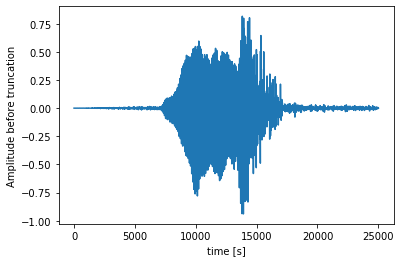

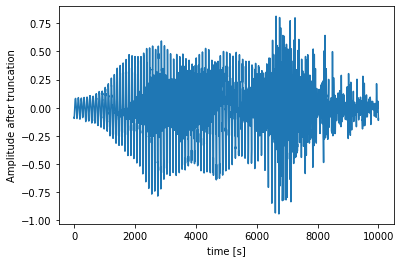

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\0-1.wav
logistic: 
['nine']
random forest: 
['zero']


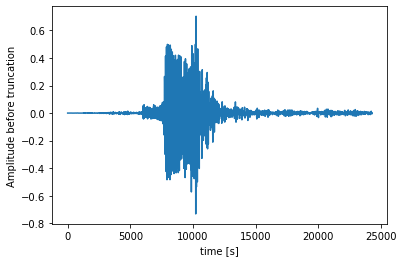

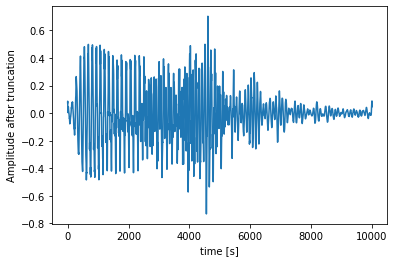

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\2-1.wav
logistic: 
['seven']
random forest: 
['six']


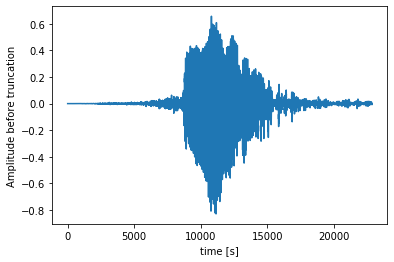

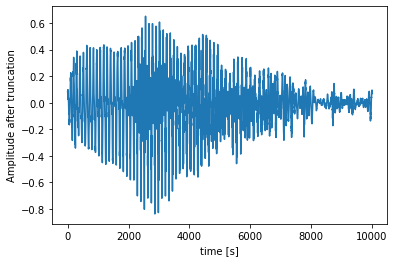

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\3-1.wav
logistic: 
['seven']
random forest: 
['eight']


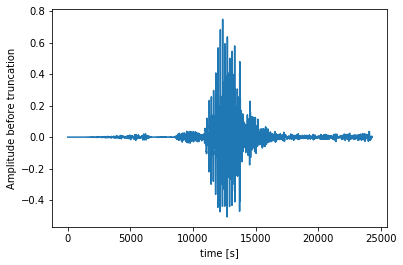

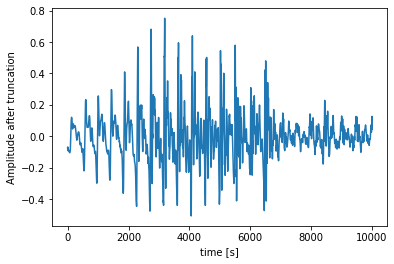

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\4-1.wav
logistic: 
['six']
random forest: 
['six']


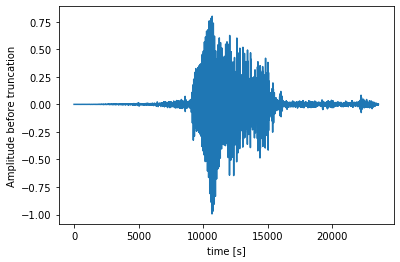

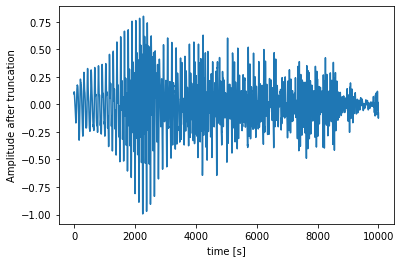

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\4-2.wav
logistic: 
['four']
random forest: 
['four']


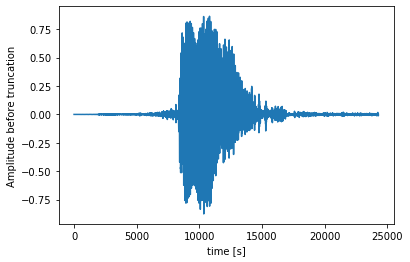

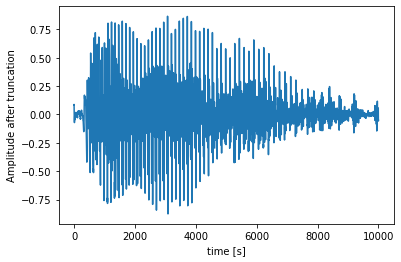

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\5-1.wav
logistic: 
['five']
random forest: 
['five']


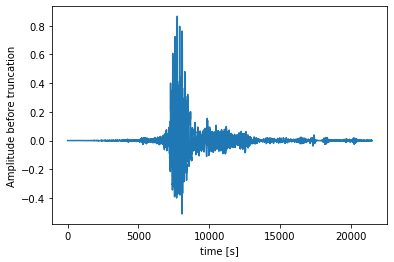

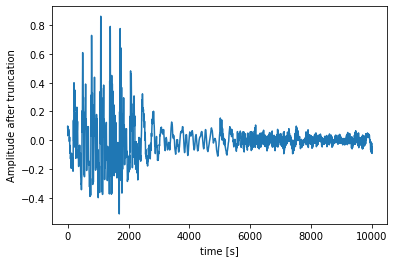

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\6-1.wav
logistic: 
['six']
random forest: 
['eight']


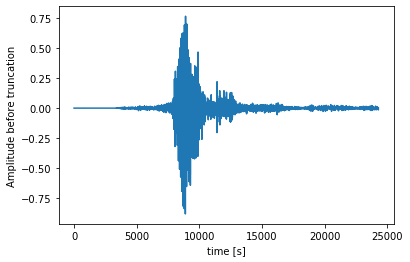

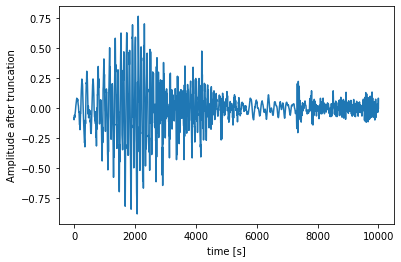

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\6-2.wav
logistic: 
['six']
random forest: 
['eight']


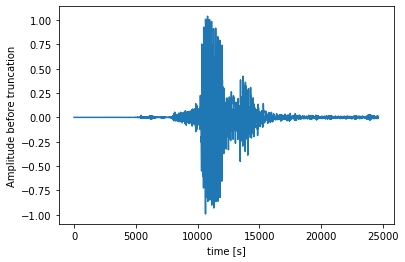

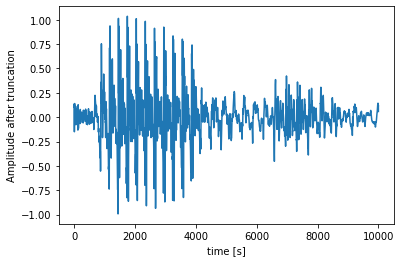

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\7-1.wav
logistic: 
['seven']
random forest: 
['eight']


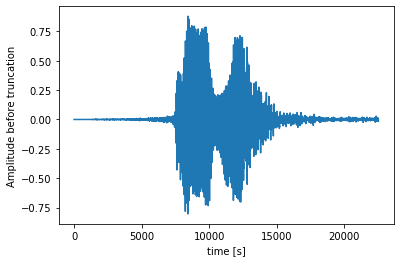

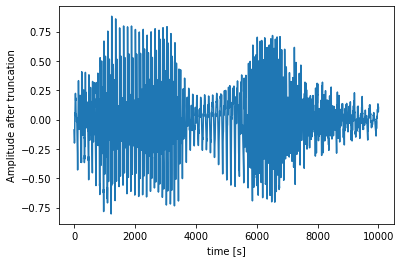

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\7-2.wav
logistic: 
['five']
random forest: 
['seven']


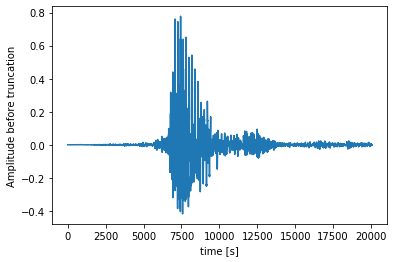

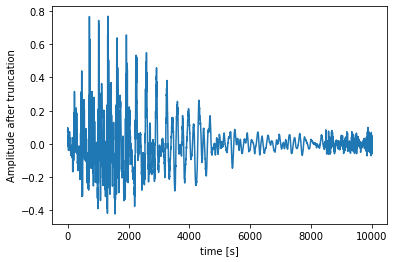

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\8-1.wav
logistic: 
['eight']
random forest: 
['eight']


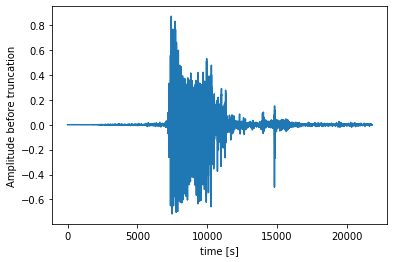

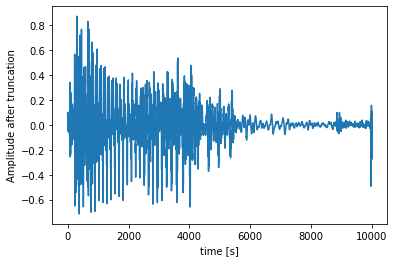

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\8-2.wav
logistic: 
['eight']
random forest: 
['eight']


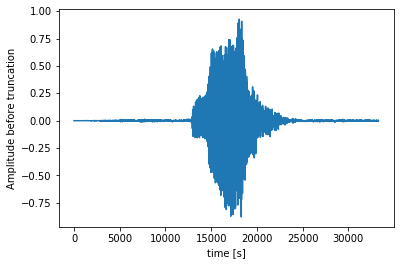

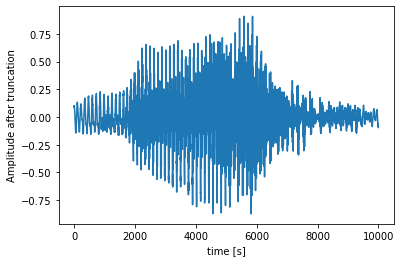

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\9-1.wav
logistic: 
['nine']
random forest: 
['nine']


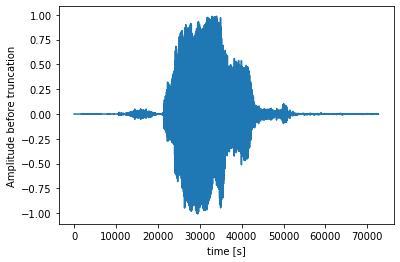

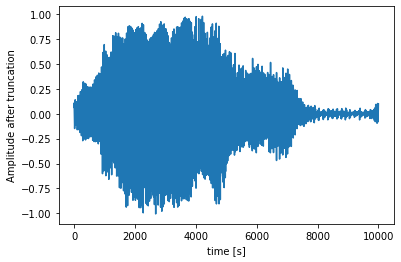

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\9-3.wav
logistic: 
['six']
random forest: 
['two']


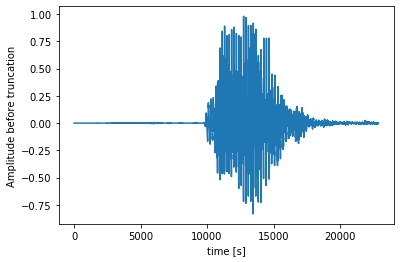

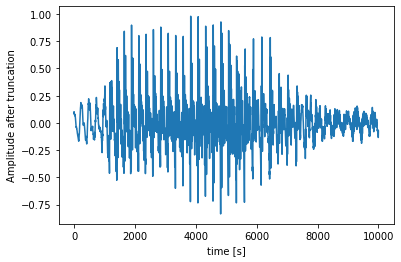

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\9-4.wav
logistic: 
['nine']
random forest: 
['nine']


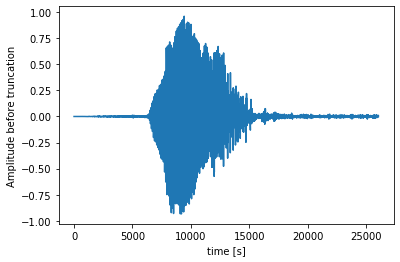

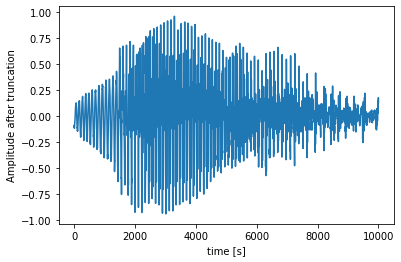

(1, 200)
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\test\9-5.wav
logistic: 
['nine']
random forest: 
['nine']


In [613]:
read_and_test_file("test", "digit")

In [ ]:
read_and_test_file("op_test", "op")